<a href="https://colab.research.google.com/github/Yoavvvvvv/Image-Processing/blob/main/Synthetic_Eyes_Dataset_construction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.5 MB/s eta 0:00:00


In [2]:
import cv2
import numpy as np
from PIL import Image as Img
from datasets import load_dataset
import matplotlib.pyplot as plt

In [3]:
import zipfile
import os
from tqdm import tqdm
import pandas as pd

import math


## Load the images data

In [4]:
from datasets import load_dataset, Image

#it takes about 5 min to load the dataset
dataset = load_dataset("student/celebA", split="train")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

In [5]:
img = dataset[0]['image']
print(img.format, img.size, img.mode)

JPEG (178, 218) RGB


In [6]:
images = dataset.to_pandas()
npImages = images.to_numpy()

In [7]:
#sanity check
print("Hugging face dataset shape: ", dataset.shape)
print("pandas dataset shape: ", images.shape)
print("np arrray shape: ", npImages.shape)

Hugging face dataset shape:  (202599, 1)
pandas dataset shape:  (202599, 1)
np arrray shape:  (202599, 1)


### Some images visualization

In [10]:
#resize parms
WIDTH = 128
HEIGHT = 128
size = (WIDTH, HEIGHT)
resized_images = []
ind= 0

for pic_file in tqdm((dataset[:5]['image'])):
  pic_thumbnails = pic_file.resize(size)
  resized_images.append(pic_thumbnails)
  print(type(pic_thumbnails))


100%|██████████| 5/5 [00:00<00:00, 415.26it/s]

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>


In [41]:
def resize_images(img):
  img_thumbnails = img.resize(size)
  return img_thumbnails

In [51]:
def print_n_original_images(n):
  fig, axes = plt.subplots(1,5, figsize = (15,3))

  for ind in range(n):
    img = resize_images(dataset[ind]['image'])
    axes[ind].imshow(img)
    axes[ind].axis('off')
  plt.show()

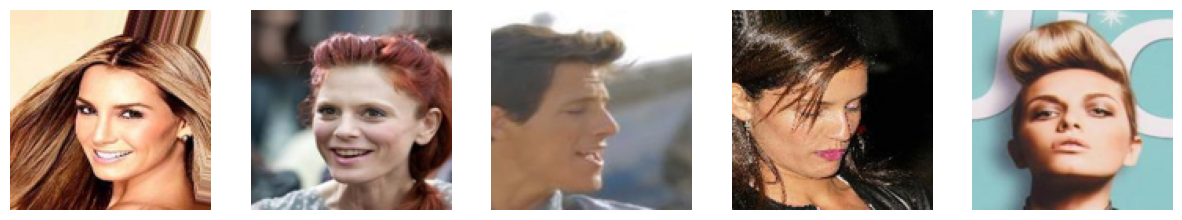

In [52]:
print_n_original_images(5)

## Face and Eye Detection

In [13]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades+ 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_eye.xml')

In [70]:
def detect_face_regions(img):
  opencv_image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
  gray_image = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray_image, scaleFactor = 1.1, minNeighbors = 5, minSize = (30,30))

  for (x,y,w,h) in faces:
    cv2.rectangle(opencv_image, (x,y), (x+w,y+h), (255,0,0), 2)

  opencv_rgb = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2RGB)

  for (x2,y2,w2,h2) in faces:
    center = (x2+w2//2, y2+h2//2)
    radius = int(max(w2,h2)*0.5)
    cv2.circle(opencv_image,center,radius,(0,0,255),2)

  return opencv_image


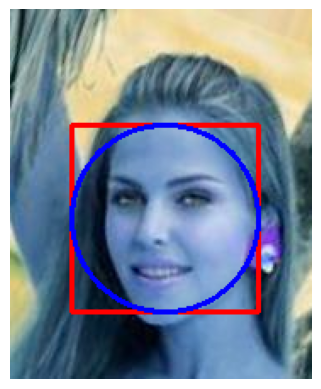

In [96]:
face_detected_img = detect_face_regions(dataset[1000]['image'])
plt.imshow(face_detected_img)
plt.axis('off')
plt.show()

In [81]:
#Detect eys region function
def detect_eyes_region(img):
  opencv_image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
  gray_image = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray_image, scaleFactor = 1.1, minNeighbors = 5, minSize = (30,30))

  for (x,y,w,h) in faces:
    roi_gray = gray_image[y:y+h, x:x+w]
    roi_color = opencv_image[y:y+h, x:x+w]

    eyes = eye_cascade.detectMultiScale(roi_gray)

    if len(eyes)>=2:
      top_left_x = min(eyes[:,0])
      top_left_y = min(eyes[:,1])

      bottom_right_x = max(eyes[:,0]+eyes[:,2])
      bottom_right_y = max(eyes[:,1]+eyes[:,3])

      cv2.rectangle(roi_color, (top_left_x,top_left_y), (bottom_right_x, bottom_right_y), (0,255,0),2)

  eyes_rect = [top_left_x,top_left_y,bottom_right_x,bottom_right_y]
  opencv_rgb = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2RGB)

  return opencv_image



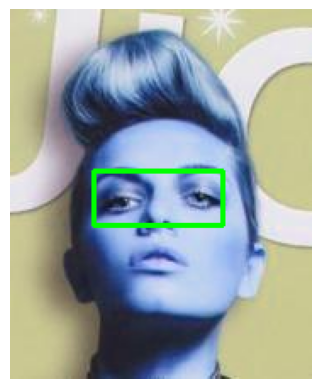

In [93]:
eyes_detected_img = detect_eyes_region(dataset[4]['image'])
plt.imshow(eyes_detected_img)
plt.axis('off')
plt.show()

In [83]:
def mask_image(img):
  opencv_image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
  gray_image = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2GRAY)


# Create a black image of the same size as the original image
  black_image = np.zeros_like(img)

# Detect faces
  faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

  for (x, y, w, h) in faces:
    # Extract the region of interest (ROI) for eyes
    roi_gray = gray_image[y:y+h, x:x+w]
    roi_color = opencv_image[y:y+h, x:x+w]

    # Detect eyes within the ROI
    eyes = eye_cascade.detectMultiScale(roi_gray)

    # Find the bounding box for both eyes
    if len(eyes) >= 2:
        # Find the minimum x, y, width, and height for both eyes
        ex_min = min(eyes[:, 0])
        ey_min = min(eyes[:, 1])
        ex_max = max(eyes[:, 0] + eyes[:, 2])
        ey_max = max(eyes[:, 1] + eyes[:, 3])

        # Draw a rectangle around both eyes
        cv2.rectangle(roi_color, (ex_min, ey_min), (ex_max, ey_max), (0, 0, 0), 2)

        # Create a mask for the eyes region
        eye_mask = np.zeros_like(roi_gray)
        cv2.rectangle(eye_mask, (ex_min, ey_min), (ex_max, ey_max), (255, 255, 255), -1)


    # Copy the eyes region from the original image to the black image using the mask
    black_image[y:y+h, x:x+w][eye_mask == 255] = opencv_image[y:y+h, x:x+w][eye_mask == 255]

  return black_image

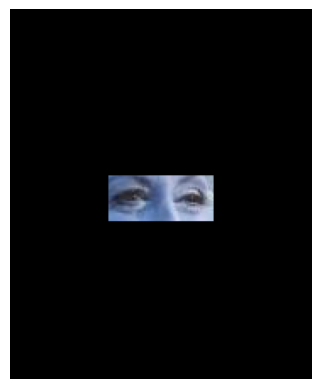

In [98]:
img2 = mask_image(dataset[251]['image'])
plt.imshow(img2)
plt.axis('off')
plt.show()

## creating a synthetic masked face partial-dataset

In [99]:
sytheticMaskedFace = []
for ind in range(10):
  img = mask_image(dataset[ind]['image'])
  sytheticMaskedFace.append(img)

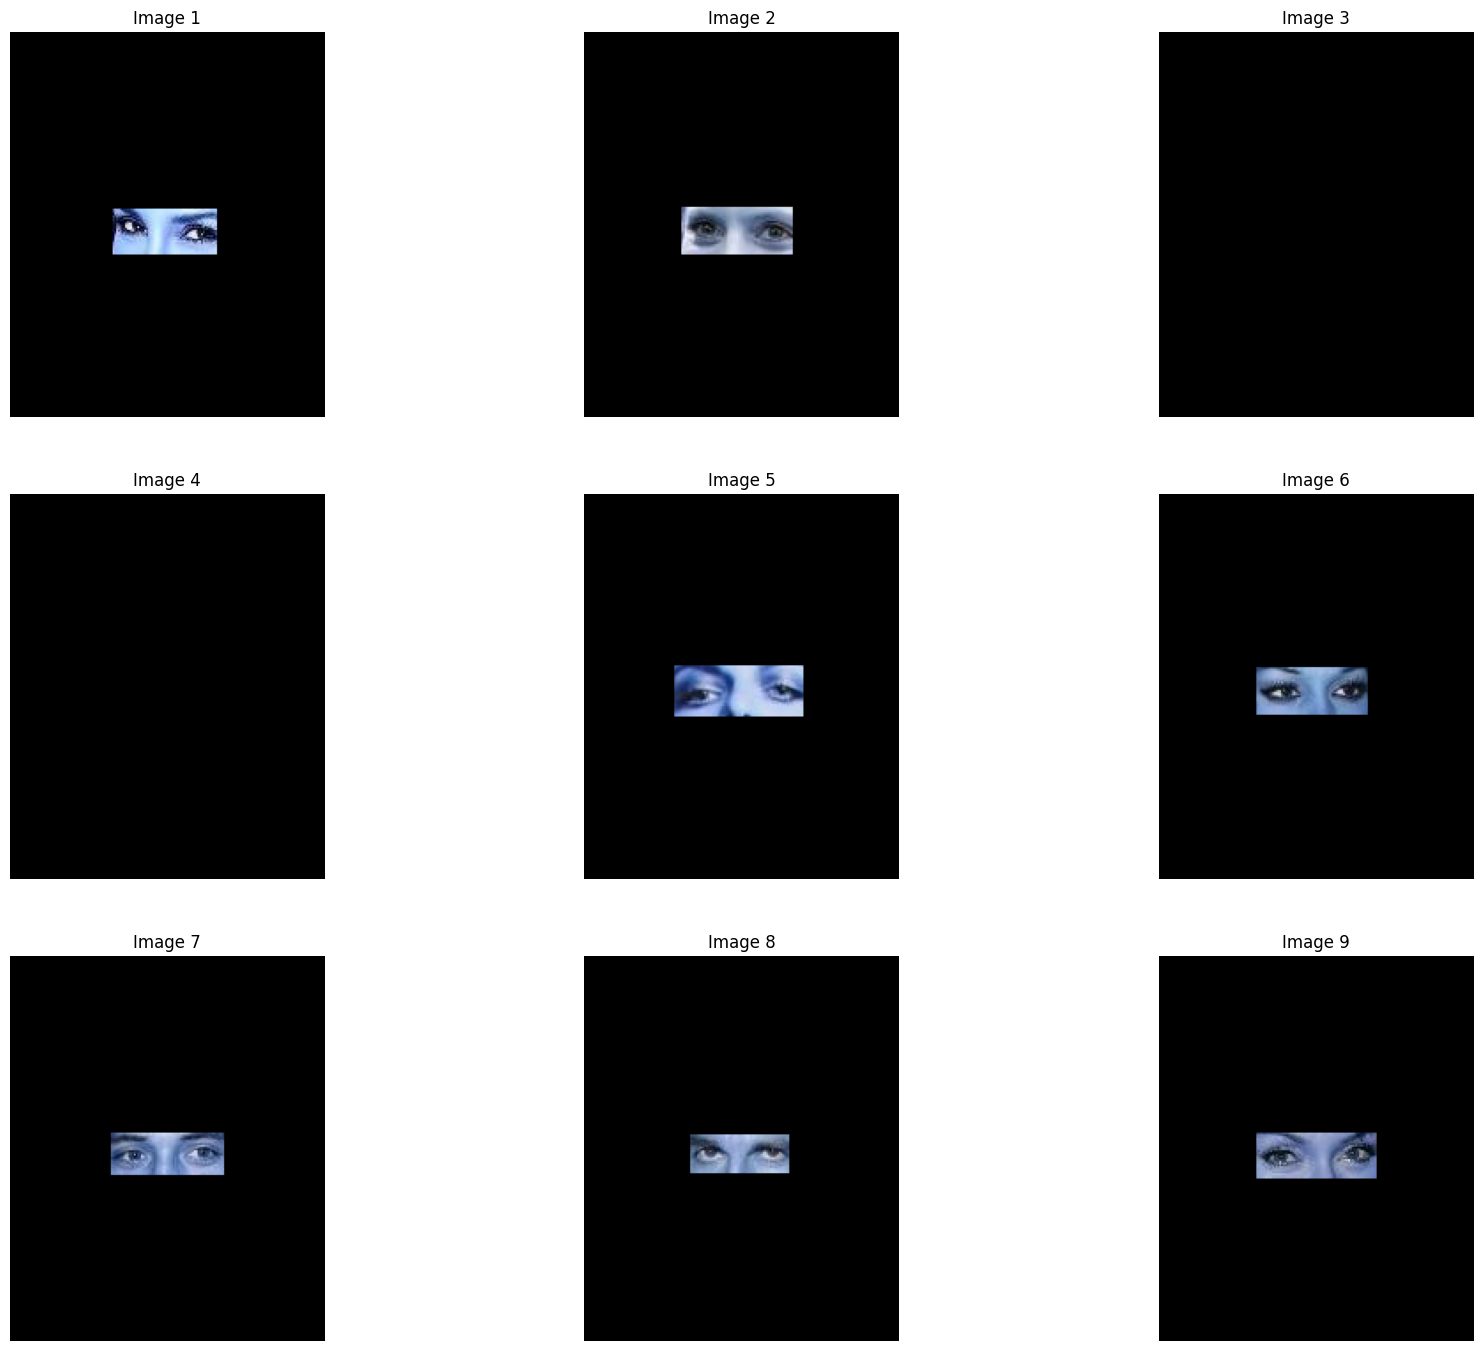

In [100]:
fig , axes = plt.subplots(3, 3, figsize=(21, 17))


for ind in range(9):
    axes[ind // 3, ind % 3 ].imshow(sytheticMaskedFace[ind])
    axes[ind // 3, ind % 3 ].axis('off')
    axes[ind // 3, ind % 3 ].set_title(f'Image {ind+1}')

## Saving the numPy array datasets

In [101]:
def save_dataset_as_array(dataset, output_file):
  np.save(output_file, dataset)

In [103]:
path = "/content/sytheticMaskedFace.npy"
save_dataset_as_array(sytheticMaskedFace, path )